- Focused on training using the ground truth (perfect RPN) bounding boxes

In [1]:
import os
import torch
import pandas as pd  
from project.dataset import Dataset, VALDODataset
from project.preprocessing import NiftiToTensorTransform, get_transform
from project.utils import collatev2, compute_statistics 
from torch.utils.data import DataLoader
from project.model import ISAVIT, feeder
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from project.model.feeder import Feeder
import seaborn as sns
import torch.nn as nn
from project.evaluation import isa_vit_metric

c:\Users\nigel\Documents\Thesis\Thesis\.env\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\nigel\Documents\Thesis\Thesis\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
from datetime import datetime as dtt
import os

path = 'runs'
os.makedirs(path, exist_ok=True)

dte = dtt.now().strftime('%b_%d_%Y_%H%M%S')
os.makedirs(f'{path}/{dte}', exist_ok=True)
os.makedirs(f'{path}/{dte}/images', exist_ok=True)
logger = logging.getLogger('nigel')
fh = logging.FileHandler(f'{path}/{dte}/ViT{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_12_2024_131357'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
image_size = 300
patch_size = 64

config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=2500
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 75,
    'loss': nn.BCEWithLogitsLoss(),
    # 'loss' : nn.L1Loss(),
    # 'loss' : nn.SmoothL1Loss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.000075
}

logger.info(f'image_size: {image_size}')
logger.info(f'patch_size: {patch_size}')
logger.info(f'Config: {config}')
logger.info(f'Further Notes:')
logger.info(f'Added dropout(0.5 inplace true) on the segmentation layer')

c:\Users\nigel\Documents\Thesis\Thesis\.env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [5]:
from project.model import Feeder, RPN, GCRPN

resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

feeder = Feeder(resize)


## Load the dataset

In [6]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 8)

In [7]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...
359,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,25,1,1,3,448.000000,39


### `DataLoader` Generator

In [8]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [9]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

In [10]:
def make_feedset(
        data,
        target_shape=(300, 300),
        rpn_mode=True,
        logger=None
    ):
    s = f'Creating feedset\n'
    paths = data.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'
    global_min, global_max = compute_statistics(paths)
    
    feedset_transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )
    feedset = VALDODataset(
    cases=data.mri,
    masks=data.masks,
    target=data.target,
    transform=feedset_transform
    )
    print(s)
    return feedset

In [11]:
train_set_ch1, val_set_ch1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False,
    batch_size=40,
    target_shape=(512, 512),    
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 8), (9, 8))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)



In [12]:
train_set_ch3, val_set_ch3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False,
    batch_size=40,
    target_shape=(512, 512),    
)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 8), (10, 8))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 664.0)



In [13]:
feedset = make_feedset(
    data=data,
    rpn_mode=True,
    target_shape=(512, 512)
)

Creating feedset
Total Unique MRI Samples in data_train: 50
GLOBAL MIN & MAX (0.0, 88731.5390625)



In [14]:
from torch.utils.data import ConcatDataset

train_set = ConcatDataset([train_set_ch1, train_set_ch3])
val_set = ConcatDataset([val_set_ch1, val_set_ch3])
print("Combined Train Set: ", len(train_set))
print("Combined Val Set: ", len(val_set))

Combined Train Set:  73
Combined Val Set:  19


In [15]:
tl = DataLoader(
    train_set,
    shuffle=True,
    batch_size=40,
    collate_fn=collatev2
)

vl = DataLoader(
    val_set,
    shuffle=True,
    batch_size=40,
    collate_fn=collatev2
)

### Test Bounding box extraction with train and val feedset

### Fitter

In [16]:
from project import Fitter
import math
class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            print(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader)
            val_loss, val_metric = self.validation(val_loader)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                num_slices = slices.shape[0]
                
                regions = feedset.locate_case_by_mri(case)
                bboxes = regions[1].view(regions[1].shape[0], -1)
                bbox = bboxes[target].int().tolist()
                
                self.log(bbox)
                x = feeder(slices, bbox, 16)
                t = feeder(masks, bbox, 16)
                self.log(x.shape)
                self.log(t.shape)
                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                y = self.model(x, target)
                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
    
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    num_slices = slices.shape[0]
                    
                    regions = feedset.locate_case_by_mri(case)
                    bboxes = regions[1].view(regions[1].shape[0], -1)
                    bbox = bboxes[target].int().tolist()
                    self.log(bbox)
                    x = feeder(slices, bbox, 16)
                    t = feeder(masks, bbox, 16)
                    self.log(x.shape)
                    self.log(t.shape)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)

                    # print(x.shape, t.shape)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric

In [17]:
fitter = ViTFitter(config, logger=logger)

In [18]:
import winsound
try:
    thist, vhist, train_metric_hist, val_metric_hist = fitter.fit(tl, vl)
except Exception as e:
    print(e)
    winsound.Beep(500, 1000)

EPOCH 0 ==============================
EPOCH 1 ==============================
EPOCH 2 ==============================
EPOCH 3 ==============================
EPOCH 4 ==============================
EPOCH 5 ==============================
EPOCH 6 ==============================
EPOCH 7 ==============================
EPOCH 8 ==============================
EPOCH 9 ==============================
EPOCH 10 ==============================
EPOCH 11 ==============================
EPOCH 12 ==============================
EPOCH 13 ==============================
EPOCH 14 ==============================
EPOCH 15 ==============================
EPOCH 16 ==============================
EPOCH 17 ==============================
EPOCH 18 ==============================
EPOCH 19 ==============================
EPOCH 20 ==============================
EPOCH 21 ==============================
EPOCH 22 ==============================
EPOCH 23 ==============================
EPOCH 24 ==============================
EPOCH 25 =

In [19]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

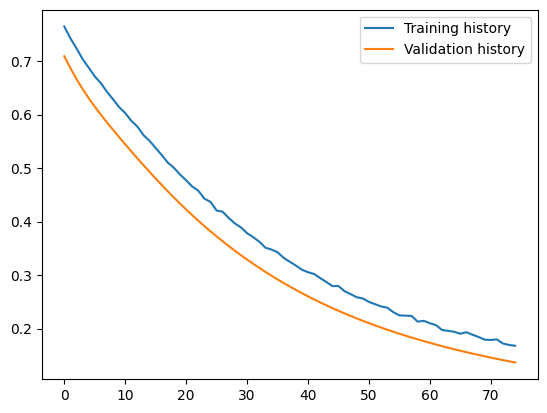

In [20]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training history')
sns.lineplot(vh.mean(1), label='Validation history')
plt.savefig(f'runs/{dte}/ViT{dte}.png')

In [21]:
model = fitter.model

s = f'runs/{dte}/{dte}ViT_GT{dte}.pt'
s

torch.save(model.state_dict(), s)

In [22]:
model = fitter.model


In [23]:
sample = next(enumerate(tl))
case = sample[1][0]
slices, masks, target, path = case

<Axes: >

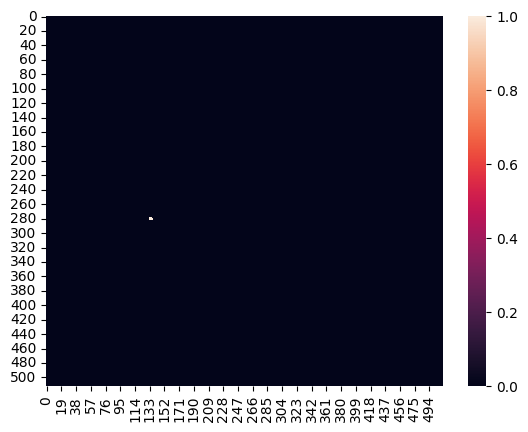

In [24]:
sns.heatmap(masks[target].squeeze())

In [25]:
slices = slices.squeeze(1).float()
masks = masks.float()
regions = feedset.locate_case_by_mri(path)
bboxes = regions[1].view(regions[1].shape[0], -1)
bbox = bboxes[target].int().tolist()

In [26]:
x = feeder(slices, bbox, 16)
t = feeder(masks, bbox, 16)

In [27]:
x.shape

torch.Size([35, 1, 64, 64])

In [28]:
x[target].shape

torch.Size([1, 64, 64])

In [29]:
y = model(x.flatten(2).to(device), target)

In [30]:
x.shape, y.shape, t[target].shape

(torch.Size([35, 1, 64, 64]), torch.Size([1, 4096]), torch.Size([1, 64, 64]))

In [31]:
y = y.view(patch_size, patch_size)

torch.Size([64, 64])


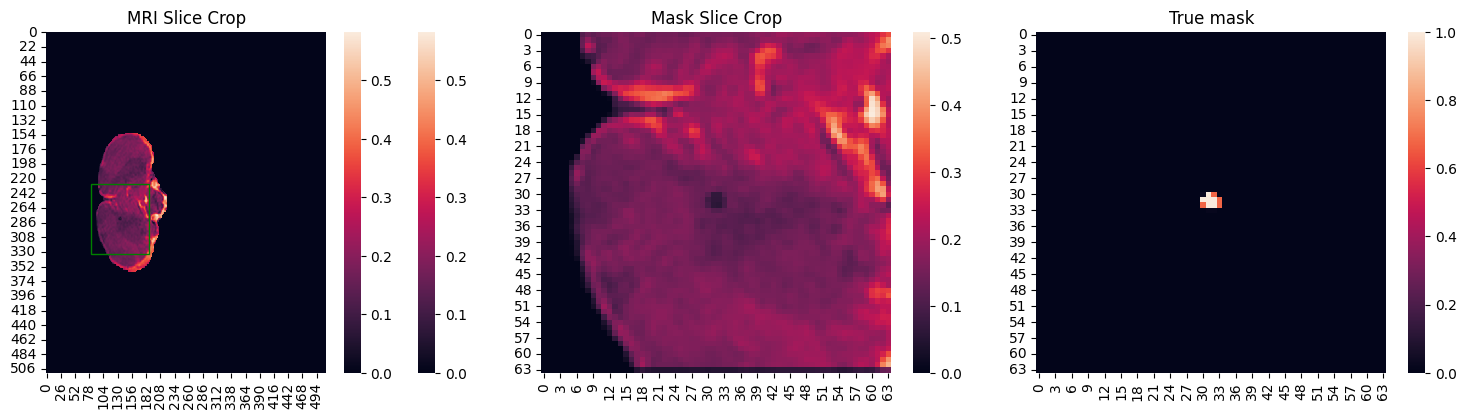

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
f, a = plt.subplots(1, 3, figsize=(15, 4))

f.tight_layout()

ax1 = a.flat[0]
ax2 = a.flat[1]
ax3 = a.flat[2]

ax1.set_title('MRI Slice Crop')
ax2.set_title('Mask Slice Crop')
ax3.set_title('True mask')

sns.heatmap(slices[target].squeeze(), ax=ax1)
box = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1, edgecolor='g', facecolor='none'
)


print(x[target].squeeze().shape)
sns.heatmap(slices[target].squeeze(), ax=ax1)
ax1.add_patch(box)
sns.heatmap(x[target].cpu().squeeze(), ax=ax2)
sns.heatmap(t[target].squeeze(), ax=ax3)

plt.show()
plt.savefig(f'runs/{dte}/images/{dte}_sample.png')

In [33]:
x.shape

torch.Size([35, 1, 64, 64])

In [34]:
y = model(x.flatten(2).to(device), target)
y = y.view(patch_size, patch_size)

In [35]:
y

tensor([[-1.5919, -1.8675, -2.2537,  ..., -2.1828, -1.5714, -1.8875],
        [-2.0015, -1.9477, -1.5367,  ..., -2.5857, -2.1141, -1.7180],
        [-1.8127, -1.5344, -2.0220,  ..., -1.7714, -2.2236, -2.0824],
        ...,
        [-1.7663, -2.1520, -1.7829,  ..., -2.0685, -1.8154, -2.1645],
        [-1.8357, -2.2351, -1.8656,  ..., -2.2226, -2.5990, -2.1695],
        [-2.3923, -2.1743, -1.9625,  ..., -2.1749, -2.1215, -1.7347]],
       device='cuda:0', grad_fn=<ViewBackward0>)

tensor([[0.1691, 0.1338, 0.0950,  ..., 0.1013, 0.1720, 0.1315],
        [0.1190, 0.1248, 0.1770,  ..., 0.0701, 0.1077, 0.1521],
        [0.1403, 0.1774, 0.1169,  ..., 0.1454, 0.0977, 0.1108],
        ...,
        [0.1460, 0.1041, 0.1440,  ..., 0.1122, 0.1400, 0.1030],
        [0.1376, 0.0966, 0.1340,  ..., 0.0977, 0.0692, 0.1025],
        [0.0838, 0.1021, 0.1232,  ..., 0.1020, 0.1070, 0.1500]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)


<Axes: title={'center': 'Mask Truth'}>

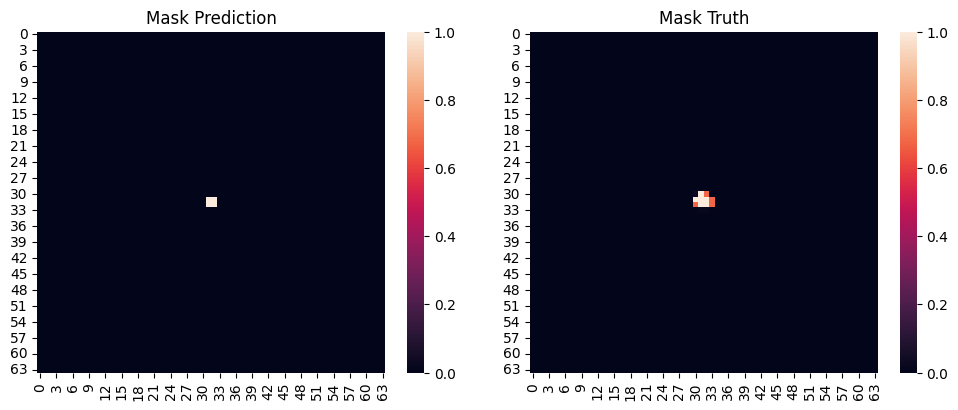

In [36]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')
print(y.sigmoid())
sns.heatmap((y.sigmoid() > 0.4).detach().cpu(), ax=ax1, vmax=1)
sns.heatmap(t[target].squeeze(), ax=ax2, vmax=1)

In [37]:
import re
def extract_number_from_filename(filename):
    match = re.search(r'sub-(\d+)', filename)
    if match:
        return match.group(1)
    return None

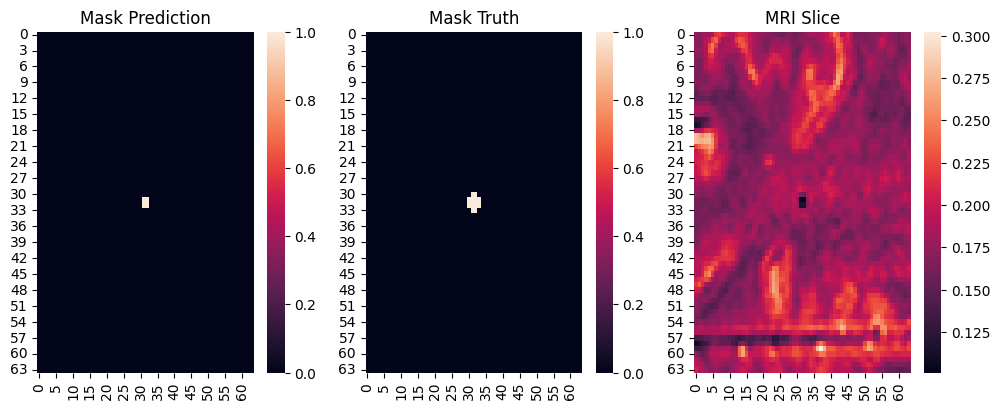

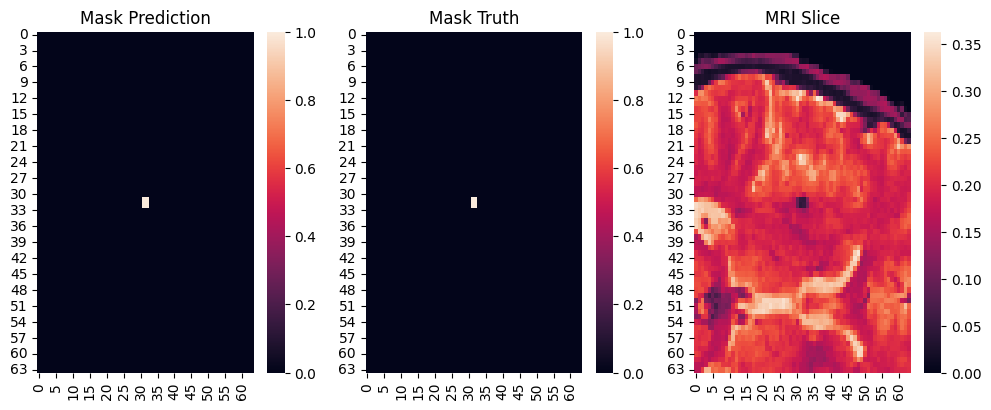

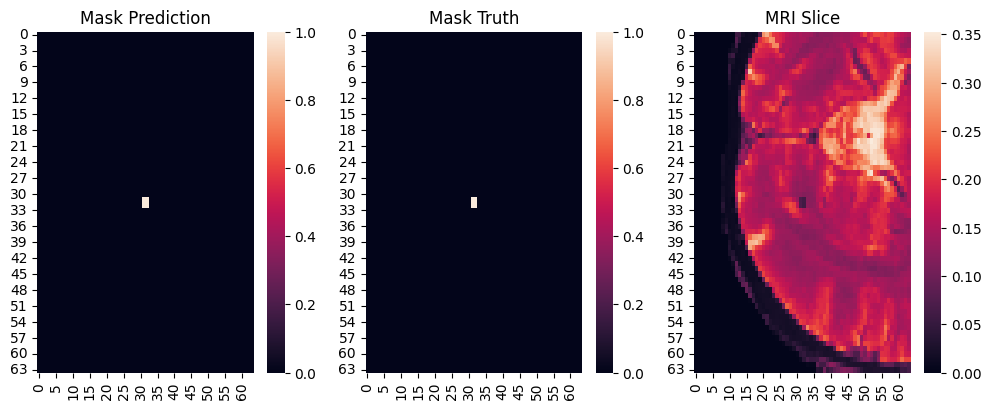

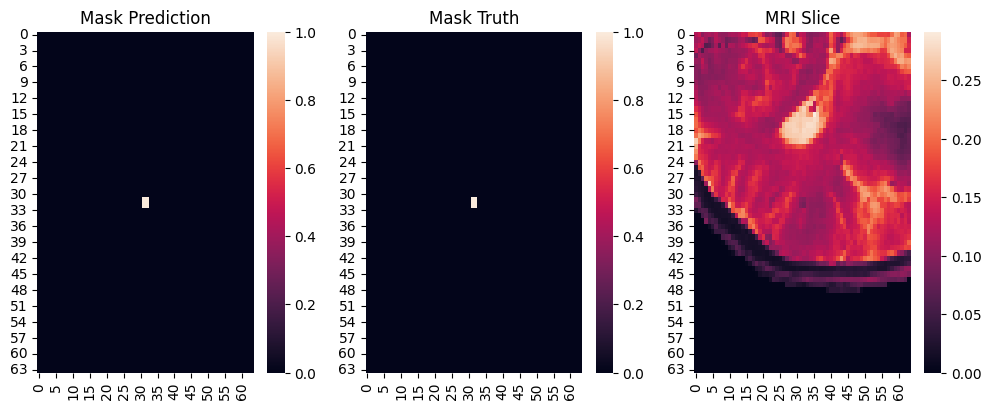

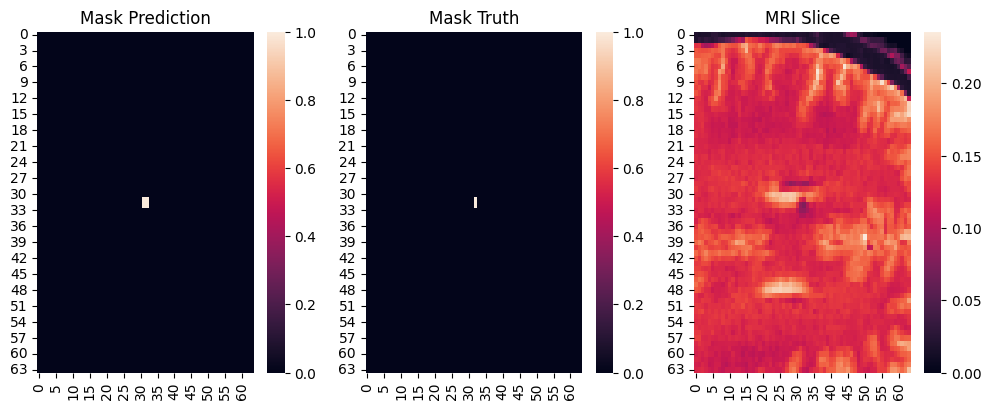

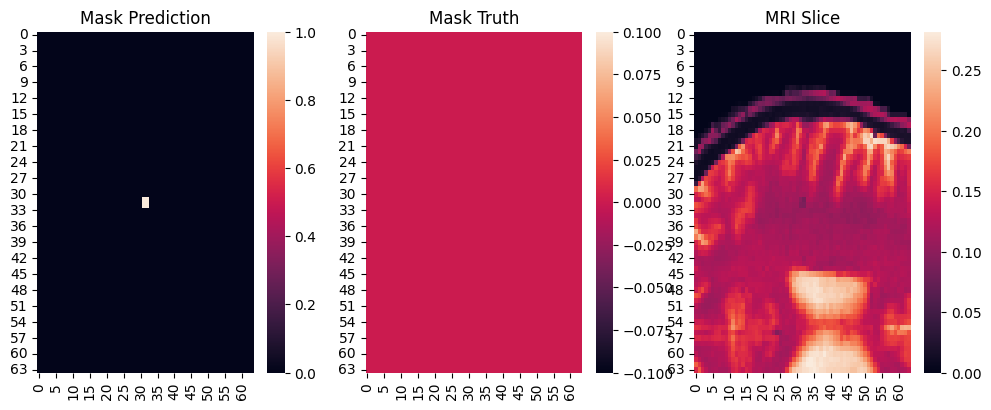

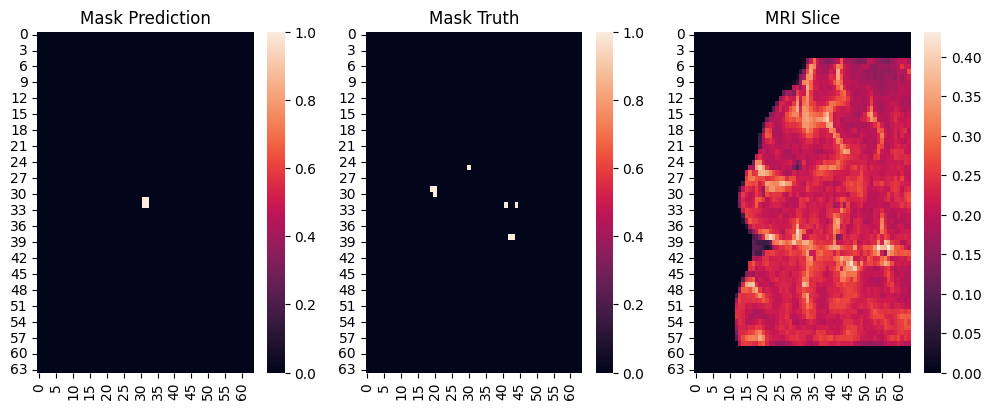

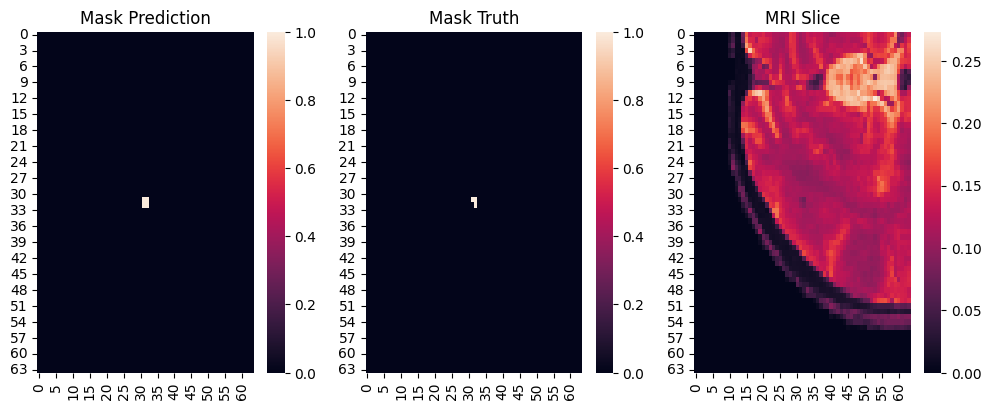

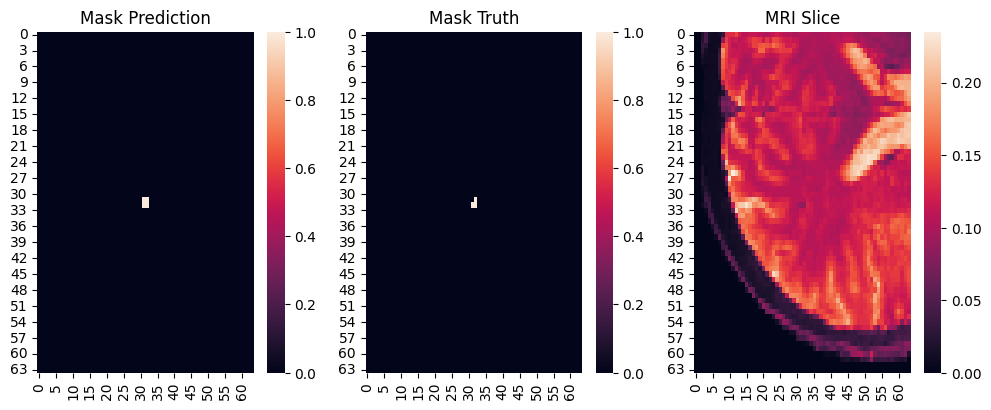

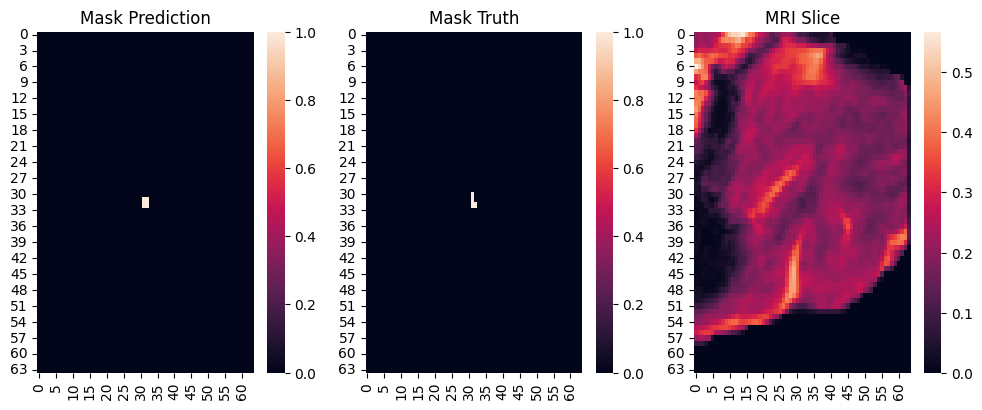

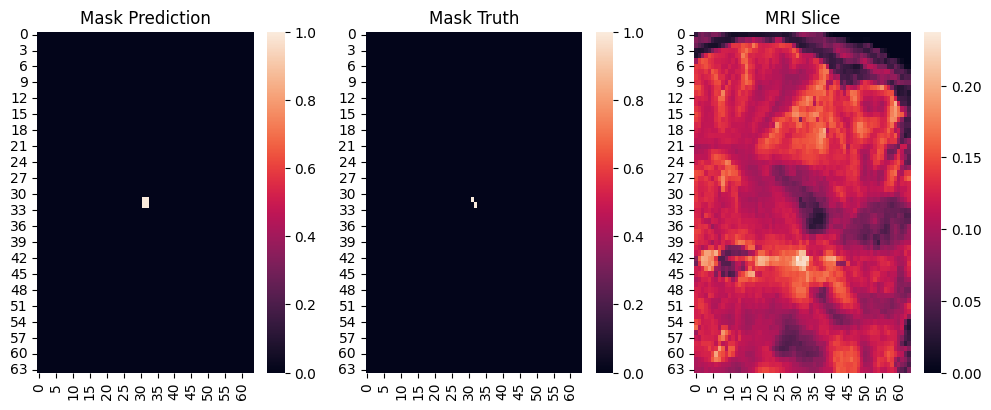

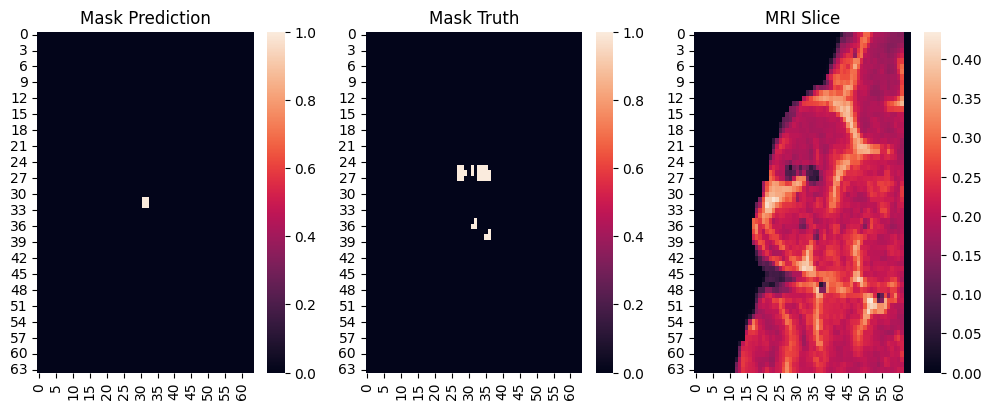

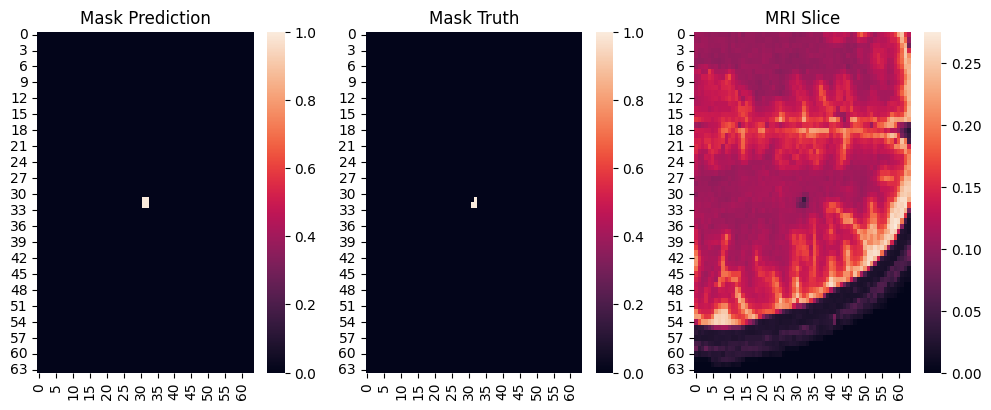

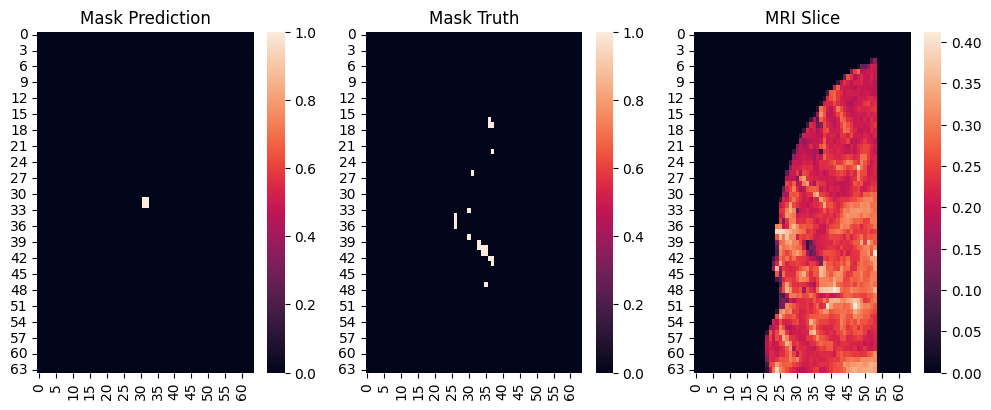

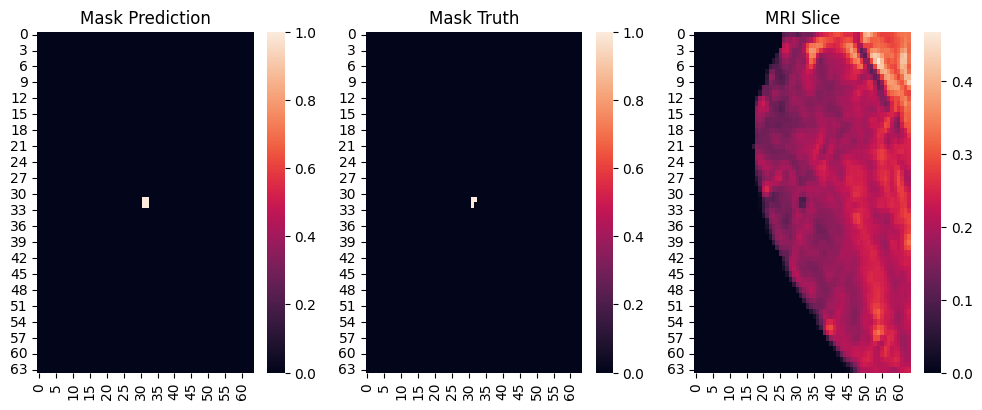

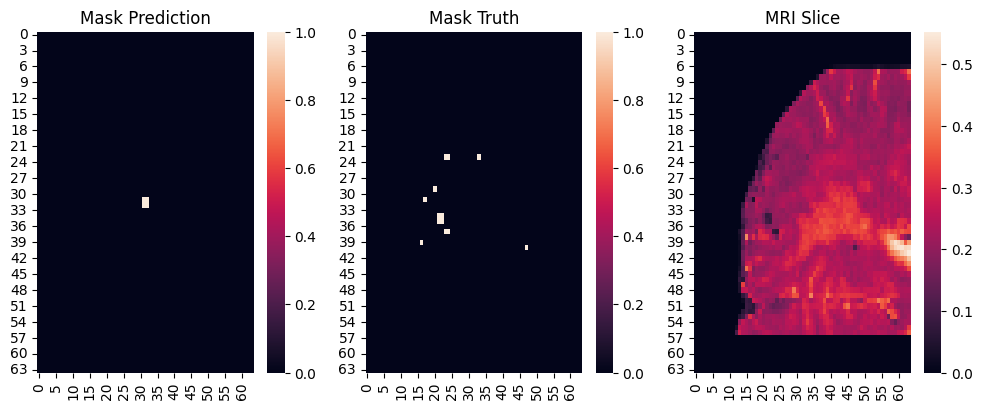

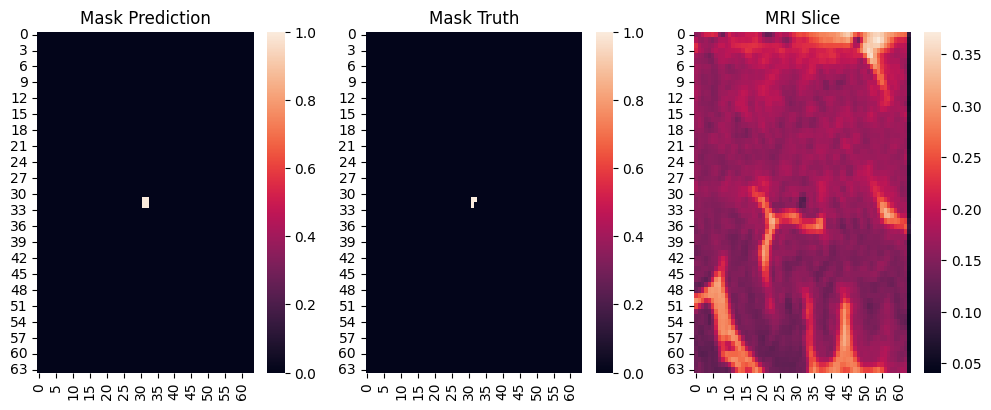

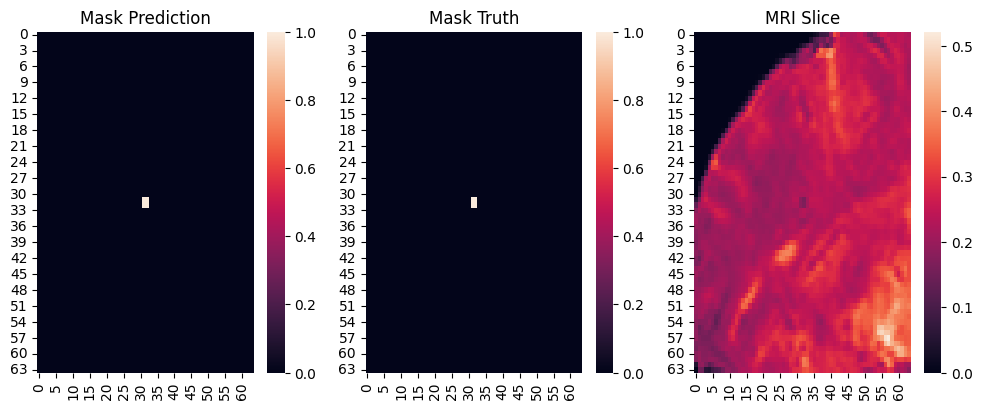

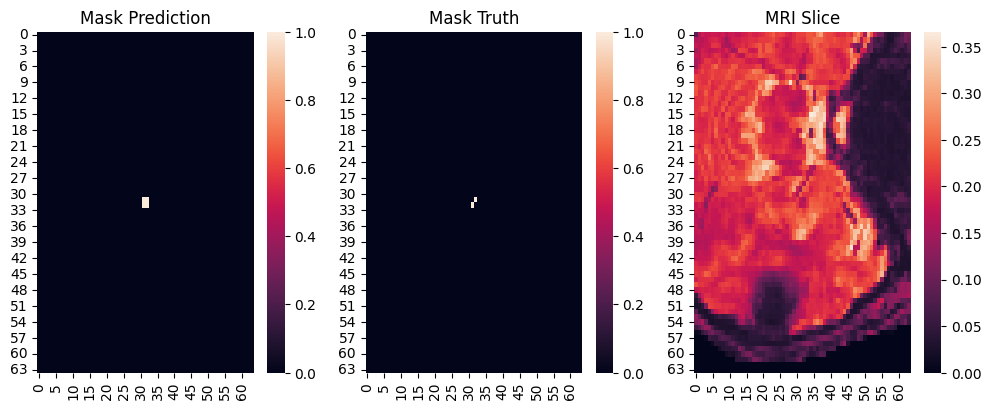

In [38]:
threshold = 0.4
tr = str(threshold).replace('.', '_')
logger.info(f'Threshold: {threshold}================================================')
os.makedirs(f'runs/{dte}/images/Threshold{tr}', exist_ok=True)
for batch in vl:
    Y = []
    T = []
    for slices, masks, target, case in batch:
        num_slices = slices.shape[0]
        
        regions = feedset.locate_case_by_mri(case)
        bboxes = regions[1].view(regions[1].shape[0], -1)
        bbox = bboxes[target].int().tolist()
        
        x = feeder(slices, bbox, 16)
        t = feeder(masks, bbox, 16)
        # t = t.flatten(2).float().to(device)

        # print(x.shape, t.shape)
        y = model(x.flatten(2).float().to(device), target)
        y = y.view(patch_size, patch_size)
        f, a = plt.subplots(1, 3, figsize=(10, 4))

        f.tight_layout()
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax3 = a.flat[2]
        ax1.set_title('Mask Prediction')
        ax2.set_title('Mask Truth')
        ax3.set_title('MRI Slice')
        
        sns.heatmap((y.sigmoid() > threshold).detach().cpu(), ax=ax1, vmax=1)
        sns.heatmap(t[target].squeeze(), ax=ax2)
        sns.heatmap(x[target].cpu().squeeze(), ax=ax3)
        # plt.title(f'Case {case} Slice {target}\n')
        casenum = extract_number_from_filename(case)
        plt.savefig(f'runs/{dte}/images/Threshold{tr}/sample_{casenum}_{target}.png')

# Metrics

In [39]:
train_set_ch1, val_set_ch1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False,
    batch_size=40,
    target_shape=(512, 512),    
)

train_set_ch3, val_set_ch3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False,
    batch_size=40,
    target_shape=(512, 512),    
)

from torch.utils.data import ConcatDataset

train_set = ConcatDataset([train_set_ch1, train_set_ch3])
val_set = ConcatDataset([val_set_ch1, val_set_ch3])
print("Combined Train Set: ", len(train_set))
print("Combined Val Set: ", len(val_set))

tl = DataLoader(
    train_set,
    shuffle=True,
    batch_size=40,
    collate_fn=collatev2
)

vl = DataLoader(
    val_set,
    shuffle=True,
    batch_size=40,
    collate_fn=collatev2
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 8), (9, 8))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 8), (10, 8))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 664.0)

Combined Train Set:  73
Combined Val Set:  19


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from torchmetrics.functional.segmentation import generalized_dice_score

In [41]:
vit = config['model']
vit.load_state_dict(torch.load(s))

C:\Users\nigel\AppData\Local\Temp\ipykernel_22592\148068204.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load(s))


<All keys matched successfully>

In [42]:
import torch
sample_tensor = torch.randint(0, 2, (4, 5, 16, 16))
print(sample_tensor.shape)

torch.Size([4, 5, 16, 16])


Source of the functions: https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f

same precision and recall computation from https://labelyourdata.com/articles/object-detection-metrics

Meron din dice na metric from torchmetrics pero same lang naman ng score from the link above


In [43]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    if total_sum == 0:
        return 0
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 4) #round up to 4 decimal places

def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    if total_pixel_pred == 0:
        return 0
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 4)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    if total_pixel_truth == 0:
        return 0
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 4)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    if (union + xor - intersect) == 0:
        return 0
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 4)

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    if union == 0:
        return 0
    iou = np.mean(intersect/union)
    return round(iou, 4)

In [44]:
vl = DataLoader(
    val_set,
    shuffle=True,
    batch_size=1,
    collate_fn=collatev2
)

In [ ]:
iou_scores = []
preds = []
truths = []
cases = []
targets = []
precision_scores = []
recall_scores = []
dice_scores = []
accuracy_scores = []
counter = 0

for batch in enumerate(vl):
    slices, masks, target, case = batch[1][0]
    slices = slices.squeeze(1).float().to(device)
    masks = masks.float().to(device)
    # with torch.inference_mode():
    #     x, t = stone(slices, masks, target)

    regions = feedset.locate_case_by_mri(case)
    bbox = regions[1][target].squeeze().round().int().tolist()
                
    x = feeder(slices, bbox, 100)
    t = feeder(masks, bbox, 100)
    
    x = x.flatten(2).to(device)
    t = t.flatten(2).to(device)
    y = vit(x, target)

    y = y.view(1, patch_size, patch_size).unsqueeze(1)
    t = t[target].view(1, patch_size, patch_size).unsqueeze(1)
    y = y.sigmoid()
    y = (y > threshold)
    
    print('Dice from torchmetrics:', generalized_dice_score(t, y, num_classes=1, per_class=True))

    y = y.squeeze().detach().cpu().numpy()
    t = t.squeeze().detach().cpu().numpy()

    dice_score = dice_coef(t, y)
    precision_score = precision_score_(t, y)
    recall_score = recall_score_(t, y)
    accuracy_score = accuracy(t, y)
    iou_score = iou(t, y)

    print('Dice from medium:', dice_score)
    print('Precision from medium:', precision_score)
    print('Recall from medium:', recall_score)
    print('Accuracy from medium:', accuracy_score)
    print('IOU from medium:', iou_score)
    print()
    logger.info(f'Dice from medium: {dice_score}')
    logger.info(f'Precision from medium: {precision_score}')
    logger.info(f'Recall from medium: {recall_score}')
    logger.info(f'Accuracy from medium: {accuracy_score}')
    logger.info(f'IOU from medium: {iou_score}')
    

    iou_scores.append(iou_score)
    preds.append(y)
    truths.append(t)
    cases.append(case)
    targets.append(target)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    dice_scores.append(dice_score)
    accuracy_scores.append(accuracy_score)
    
    counter += 1


Dice from torchmetrics: tensor([[0.7624]], device='cuda:0')
Dice from medium: 0.7624
Precision from medium: 0.616
Recall from medium: 1.0
Accuracy from medium: 0.9996
IOU from medium: 0.616

Dice from torchmetrics: tensor([[0.]], device='cuda:0')
Dice from medium: 0.0
Precision from medium: 0.0
Recall from medium: 0.0
Accuracy from medium: 0.9956
IOU from medium: 0.0

Dice from torchmetrics: tensor([[1.]], device='cuda:0')
Dice from medium: 1.0
Precision from medium: 1.0
Recall from medium: 1.0
Accuracy from medium: 1.0
IOU from medium: 1.0

Dice from torchmetrics: tensor([[0.9019]], device='cuda:0')
Dice from medium: 0.9019
Precision from medium: 0.8213
Recall from medium: 1.0
Accuracy from medium: 0.9998
IOU from medium: 0.8213

Dice from torchmetrics: tensor([[0.9077]], device='cuda:0')
Dice from medium: 0.9077
Precision from medium: 0.9023
Recall from medium: 0.913
Accuracy from medium: 0.9998
IOU from medium: 0.8309

Dice from torchmetrics: tensor([[0.]], device='cuda:0')
Dice fro

In [46]:
def avg(scores):
    return sum(scores) / len(scores)

In [47]:
print('IOU:', round(avg(iou_scores), 3))
print('Precision:', round(avg(precision_scores), 3))
print('Recall', round(avg(recall_scores), 3))
print('Dice', round(avg(dice_scores), 3))
print('Accuracy', round(avg(accuracy_scores), 3))

logger.info(f'IOU: {round(avg(iou_scores), 3)}')
logger.info(f'Precision: {round(avg(precision_scores), 3)}')
logger.info(f'Recall: {round(avg(recall_scores), 3)}')
logger.info(f'Dice: {round(avg(dice_scores), 3)}')
logger.info(f'Accuracy: {round(avg(accuracy_scores), 3)}')


IOU: 0.468
Precision: 0.556
Recall 0.632
Dice 0.564
Accuracy 0.998


2
1.0
1.0
1.0
1.0


<Axes: title={'center': 'Mask Truth'}>

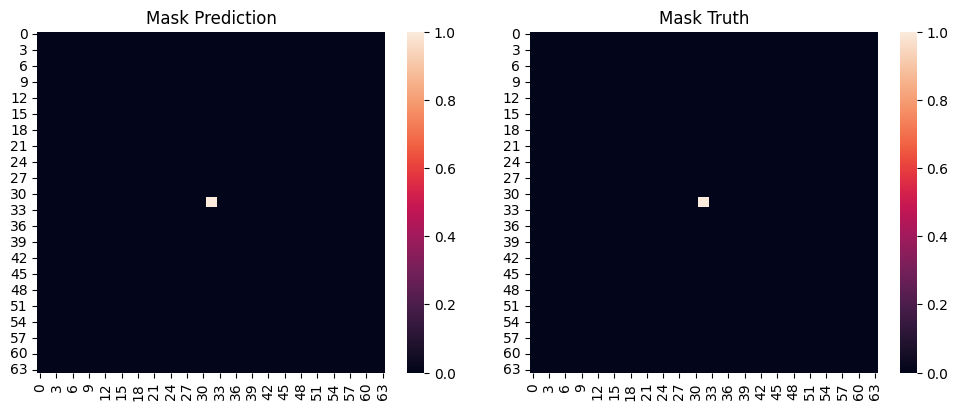

In [48]:
num = precision_scores.index(max(precision_scores))
print(num)

f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')

pred = preds[num]
truth = truths[num]

print(dice_scores[num])
print(iou_scores[num])
print(recall_scores[num])
print(precision_scores[num])

sns.heatmap(pred, ax=ax1, vmax=1)
sns.heatmap(truth, ax=ax2, vmax=1)